In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import pickle
from collections import defaultdict
import pandas as pd
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.path import Path
import tskit as tsk
import statsmodels.api as sm
from scipy.ndimage import gaussian_filter1d


from bgspy.utils import bin_chrom, bin_chroms, read_centro
from bgspy.plots import get_figax

from bgspy.theory2 import Q2_asymptotic, Q2_sum_integral, Q2_sum_integral2
from bgspy.theory2 import ave_het, bgs_segment_sc16_vec, bgs_segment_sc16
from bgspy.theory2 import bgs_rec
from bgspy.theory2 import bgs_segment_sc16_parts
from bgspy.theory2 import Ne_t, Ne_asymp2, Ne_asymp
from bgspy.theory2 import Qr_asymp, Qr_asymp2
from bgspy.theory2 import Qr_fixed, Qr_fixed2
from bgspy.theory2 import Ne_t_full2

In [3]:
# there appears to be a bug in matplotlib where the rcParams
# are only not ignored if I call plt.show() first...
plt.show()

In [4]:
plt.style.use('./buffalo.mplstyle')
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200

In [5]:
mpl.__version__, plt.rcParams['figure.dpi'], plt.rcParams['figure.figsize']

('3.7.1', 200.0, [8.0, 4.0])

In [6]:
# fixed params from the sims
L = 100_000
N = 1_000
rbp = 1e-8

## Data

### Input Data

 - `../slim_sims/region/runs/region/N__1000/mu__1e-08/sh__0.001/rbp__1e-08/`: a directory of tree results to show diversity over chromosome.
 
 - `../slim_sims/region/region_results.pkl`: process region simulation results
 
 - `../slim_sims/chrombgs/empiricalB_chr10__expansion_false__h_0.5__results.npz`: sim results for chromosome sim build up of LD.
 
### Created Data

 - `../data/supplementary_data/region_simulation_data.tsv.gz', sep='\t', index=False)`: regional simulation data, with revised ratchet rates
 - `../data/supplementary_data/simulation_ratchet_data.tsv.gz', sep='\t', index=False)`: ratchet dataframe.
 - `../data/supplementary_data/region_theory_data.pkl`: predicted theory for the regional simulation comparison.

# Region Simulations

## Diversity along the chromosome in region simulations

When comparing theory to simulations, we must be mindful that the theory is modeling the reduction *at the middle of the chromosome*. We can see why this is important by taking a subset of the tree sequences from simulations with the same parameters and looking at windowed average diversity: 

In [7]:
tree_dir = '../slim_sims/region/runs/region/N__1000/mu__1e-08/sh__0.001/rbp__1e-08/'
tree_files = [f for f in os.listdir(tree_dir) if f.endswith('.tree')]

bins = bin_chrom(L, 1000)

pi = [tsk.load(os.path.join(tree_dir, f)).diversity(windows=bins, mode='branch') for f in tree_files]

Text(0.5, 0, 'position')

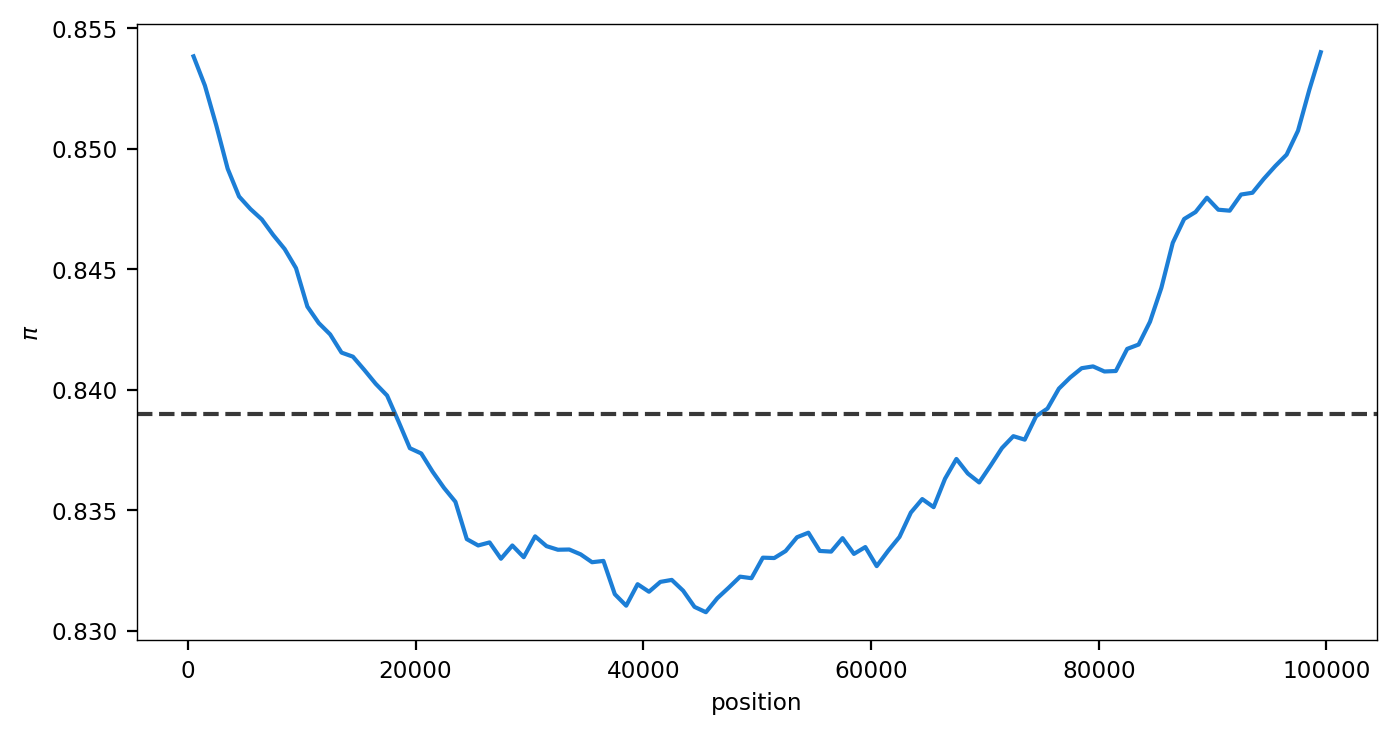

In [8]:
midpoints = (bins[1:] + bins[:-1])/2
plt.plot(midpoints, np.stack(pi).mean(axis=0)/(4*N))
plt.axhline(np.mean(pi)/(4*N), c='0.22', linestyle='dashed')
plt.ylabel("$\pi$")
plt.xlabel("position")

## Load in Simulation Results

Pre-processed by `tools/process_region_sims.py`.

NOTE: the ratchet estimates here in these data are wrong (and these take a while to run), so I correcth them below.

In [9]:
d = pd.read_pickle('../slim_sims/region/region_results.pkl')
d.head()

,cycle,k_mean,k_sd,k3,k4,f_mean,f_sd,f3,f4,s,...,B_middle,ratchet,sh,N,rbp,mu,U,r2sum,ldsum,ldn
0,9991,0.134,0.360797,0.121316,0.152642,0.999577,0.001140,-3.825070e-09,1.519620e-11,0,...,0.760940,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.00316,1000,1.000000e-08,1.000000e-09,0.0001,0.054063,0.004012,5
1,9991,0.184,0.395348,0.109579,0.112485,0.999419,0.001249,-3.456770e-09,1.120880e-11,0,...,1.224619,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.00316,1000,1.000000e-08,1.000000e-09,0.0001,0.001276,-0.001210,4
2,9991,0.000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0,...,1.390866,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.00316,1000,1.000000e-08,1.000000e-09,0.0001,0.000000,0.000000,0
3,9991,0.000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0,...,1.044498,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.00316,1000,1.000000e-08,1.000000e-09,0.0001,0.000000,0.000000,0
4,9991,0.330,0.537949,0.211854,0.325596,0.998957,0.001700,-6.684950e-09,3.246590e-11,0,...,0.851810,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.00316,1000,1.000000e-08,1.000000e-09,0.0001,0.000000,0.000000,0


In [10]:
d.columns

Index(['cycle', 'k_mean', 'k_sd', 'k3', 'k4', 'f_mean', 'f_sd', 'f3', 'f4',
       's', 'r', 'ssh', 'R', 'B', 'B_middle', 'ratchet', 'sh', 'N', 'rbp',
       'mu', 'U', 'r2sum', 'ldsum', 'ldn'],
      dtype='object')

### Ratchet Rate Correction

Note that the ratchet estimates by my processing program are biased, because I didn't trim off enough burnin. So I re-restimate those here (before the data is saved for supp data).

In [11]:
def average_ratchet_rates(d):
    data = dict()
    for mu in d['mu'].unique():
        for sh in d['sh'].unique():
            # get the ratchet values
            M = d.loc[(d['sh'] == sh) & (d['mu'] == mu)]['ratchet'].values
            D = np.stack([x for x in M]) 
            D_mean = D.mean(axis=0)
            data[(mu, sh)] = D_mean
    return data
    
def ratchet_rate_estimate(data, buffer=9000):
    rates = dict()
    for mu, sh in data.keys():
        d = data[(mu, sh)]
        if buffer is not None:
            d = d[d[:, 0] > buffer, :]
        X = sm.add_constant(d[:, 0])
        y = d[:, 1]
        fit = sm.OLS(y, X).fit()
        R = fit.params[1]
        rates[(mu, sh)] = R
    return rates
    

rate_data = average_ratchet_rates(d)
rates = ratchet_rate_estimate(rate_data)

In [12]:
# let's make a friendlier dataframe of these data

rows = []
for key in rate_data.keys():
    mu, sh = key
    for row in rate_data[key]:
        rows.append(dict(mu=mu, sh=sh, generation=row[0], fixations=row[1], rate=rates[key]))
ratchet_df = pd.DataFrame(rows)


In [13]:
d['mu'].unique()

array([1.00e-09, 3.16e-10, 3.16e-09, 1.00e-08])

In [14]:
rate_data.keys()

dict_keys([(1e-09, 0.00316), (1e-09, 0.1), (1e-09, 0.0001), (1e-09, 3.16e-05), (1e-09, 0.01), (1e-09, 0.000316), (1e-09, 0.0316), (1e-09, 0.001), (3.16e-10, 0.00316), (3.16e-10, 0.1), (3.16e-10, 0.0001), (3.16e-10, 3.16e-05), (3.16e-10, 0.01), (3.16e-10, 0.000316), (3.16e-10, 0.0316), (3.16e-10, 0.001), (3.16e-09, 0.00316), (3.16e-09, 0.1), (3.16e-09, 0.0001), (3.16e-09, 3.16e-05), (3.16e-09, 0.01), (3.16e-09, 0.000316), (3.16e-09, 0.0316), (3.16e-09, 0.001), (1e-08, 0.00316), (1e-08, 0.1), (1e-08, 0.0001), (1e-08, 3.16e-05), (1e-08, 0.01), (1e-08, 0.000316), (1e-08, 0.0316), (1e-08, 0.001)])

Text(0.5, 0, 'generation')

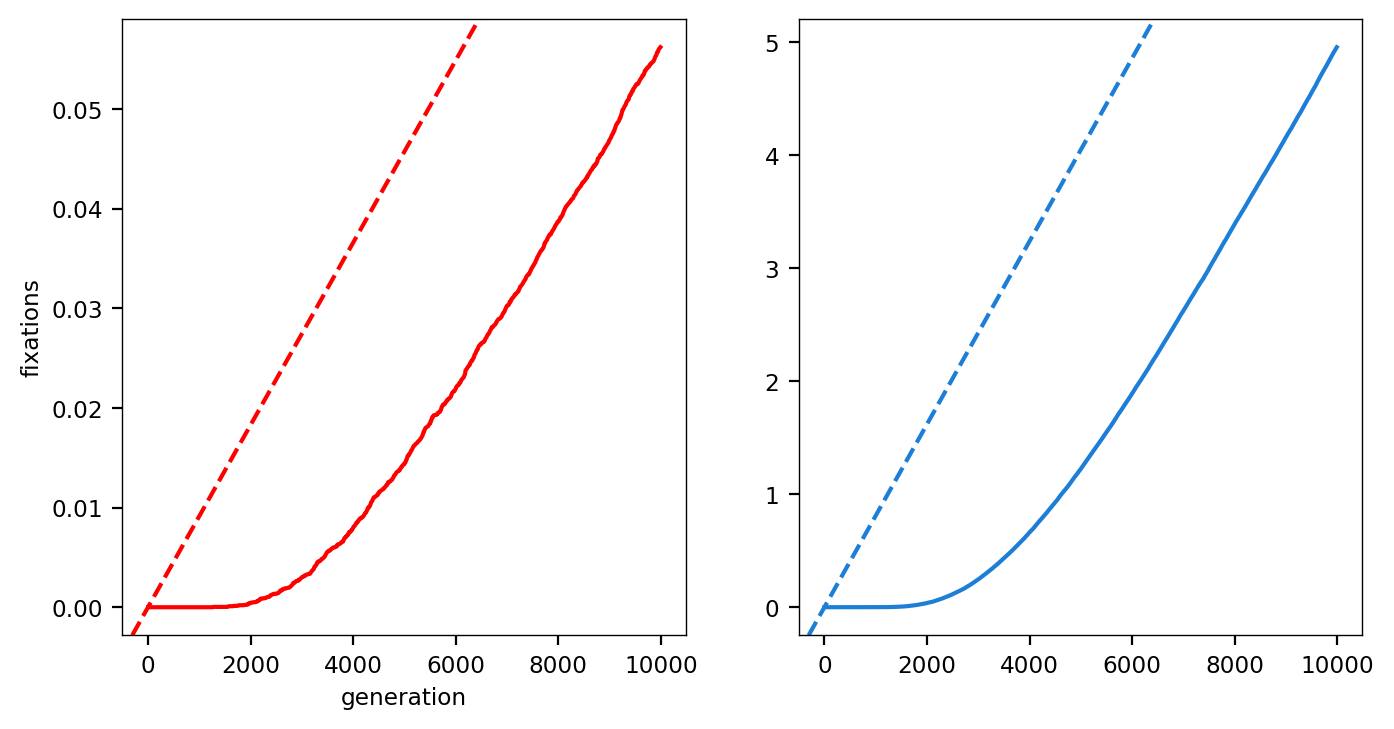

In [15]:
key_1, key_2 = (1e-09, 0.001), (1e-08, 0.0001)

fig, ax = plt.subplots(ncols=2)
ax[0].plot(*rate_data[key_1].T, c='r', label='μ = 1e-8, s=1e-5')
ax[0].axline((0, 0), slope=rates[key_1], c='r', linestyle='dashed')
ax[1].plot(*rate_data[key_2].T, label='μ = 1e-8, s=1e-3')
ax[1].axline((0, 0), slope=rates[key_2], linestyle='dashed')
ax[0].set_ylabel('fixations')
ax[0].set_xlabel('generation')
#plt.semilogy()
#ax[0].legend()

This shows that rates hit equilibria after ~4N generations.

### Save Supplementary Data

In [16]:
# let's make a friendly version of the data for saving to TSV
df = d.loc[:, ~d.columns.isin(['ratchet', 'R'])]
df.to_csv('../data/supplementary_data/region_simulation_data.tsv.gz', sep='\t', index=False)

# save the ratchet data
ratchet_df.to_csv('../data/supplementary_data/simulation_ratchet_data.tsv.gz', sep='\t', index=False)

In [17]:
d.loc[(d['mu'] == 1e-8) & (d['sh'] == 0.01)]['mu']

449930    1.000000e-08
449931    1.000000e-08
449932    1.000000e-08
449933    1.000000e-08
449934    1.000000e-08
              ...     
479917    1.000000e-08
479918    1.000000e-08
479919    1.000000e-08
479920    1.000000e-08
479921    1.000000e-08
Name: mu, Length: 29992, dtype: float64

In [18]:
# average across replicates
dg = d.groupby(['sh', 'rbp', 'N', 'mu', 'U']).mean().reset_index()

/tmp/ipykernel_45225/1740891089.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dg = d.groupby(['sh', 'rbp', 'N', 'mu', 'U']).mean().reset_index()


In [19]:
dg['sh'].unique(), dg['mu'].unique(), dg['rbp'].unique()

(array([3.16e-05, 1.00e-04, 3.16e-04, 1.00e-03, 3.16e-03, 1.00e-02,
        3.16e-02, 1.00e-01]),
 array([3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08]),
 array([1.e-08]))

# Comparing Simulations to Theory

Pre-compute all the theory data, for the regional simulations.

In [ ]:
theory_data_all = defaultdict(dict)

rbps = [rbp, 0.5e-8, 5e-8]

x = np.logspace(-5, 1, 100)

for r in rbps:
    for mu in dg['mu'].unique():
        # NOTE: we need asymptotic = False so that *everything* is computed (which is more expensive)
        parts = np.array(bgs_segment_sc16_parts(mu, x, L, r, N, asymptotic=False))
        Bs = np.array([x[0] for x in parts])
        Bs_asymp = np.array([x[1] for x in parts])
        other_stuff = [x[5:] for x in parts]
        classic_bgs = np.array([x[-1] for x in parts])
        Vs = np.array([x[3] for x in parts])
        Vms = np.array([x[4] for x in parts])    
        Ts = np.array([x[2] for x in parts])
        theory_data_all[r][mu] = x, Bs, Bs_asymp, Vs, Ts, classic_bgs, other_stuff

theory_data = theory_data_all[rbp] # main dataset

/home/vsb/projects/bprime/bgspy/theory2.py:92: RuntimeWarning: overflow encountered in exp
  out = (np.exp(4*sh*Ne) - 1)/(2*U*sh*Ne)
/home/vsb/projects/bprime/bgspy/theory2.py:326: RuntimeWarning: invalid value encountered in scalar subtract
  return [np.log(new_T) - np.log(T),
/home/vsb/projects/bprime/bgspy/theory2.py:122: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrand = quad(lambda r: ((1-(1-r)**(T+1) * Z**(T+1))/(1 - (1-r)*Z))**2, 0, M/2)[0]
/home/vsb/projects/bprime/bgspy/theory2.py:122: RuntimeWarning: overflow encountered in scalar power
  integrand = quad(lambda r

In [ ]:
# save the region predictions from theory 
with open('../data/supplementary_data/region_theory_data.pkl', 'wb') as f:
    pickle.dump(theory_data, f)

## Main Region Simulation Figures

### Figure 1A

In [444]:
theory_data[1e-8][5]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

(0.0015, 100)


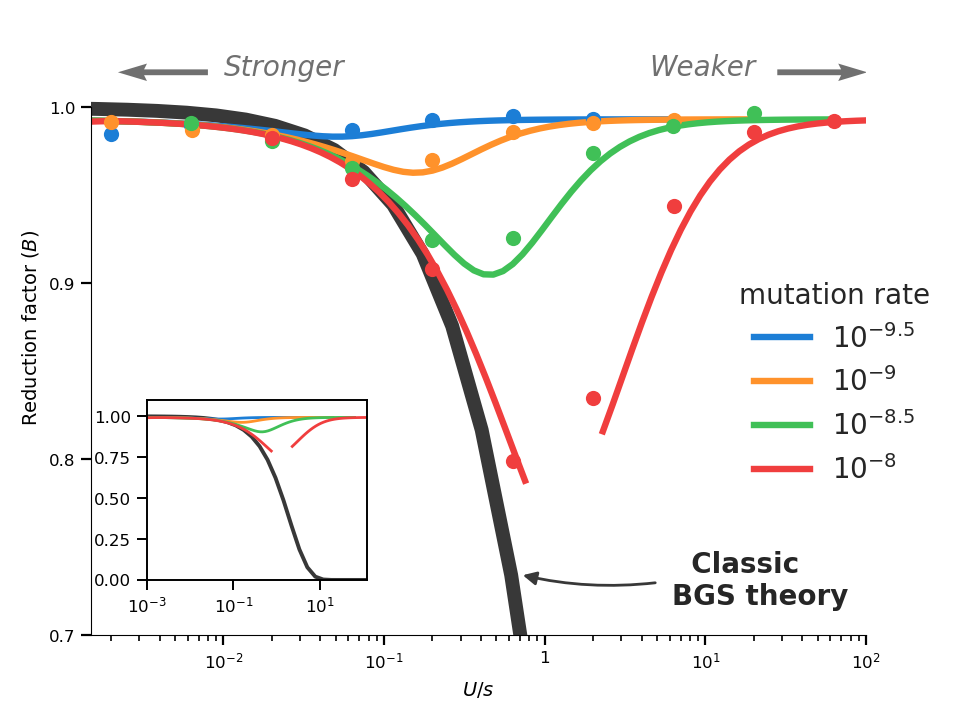

In [456]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker


def log10_formatter(x, pos):
    if x == 1.0:
        return '1'
    else:
        return '$10^{%d}$' % np.log10(x)


def B_theory_plot(sim_dg, L, rbp, N, mus=None, x=np.logspace(-5, np.log10(0.9), 50), 
                  include_asymp=True, labels=True, xlim=None, ylim=None, 
                  marker_size=5, linewidth=2, data=None,
                  bgs_linewidth=2, bgs_zorder=10, figax=None, **figax_kwargs):
    fig, ax = get_figax(figax, **figax_kwargs)
    if mus is None:
        mus = sim_dg['mu'].unique()
    for mu in mus:
        dgs = sim_dg.loc[dg['mu'] == mu]

        U = 2*mu*L
        if np.log10(mu) == int(np.log10(mu)):
            mul = int(np.log10(mu))
        else:
            mul = np.round(np.log10(mu), 2)
        mu_label = f"$10^{{{mul}}}$"
        
        # sim data
        sh = dgs['sh'].values
        rate = U/sh
        col = next(ax._get_lines.prop_cycler)['color']
        #ax.scatter(rate, dgs['B_middle'], edgecolor='white', linewidth=0.2, c=col, s=marker_size, zorder=10)
        ax.scatter(rate, dgs['B_middle'], edgecolor='white', linewidth=0, c=col, s=marker_size, zorder=10)

        # theory part
        if data is None:
            # calculate the values directly
            Bs_asymp = np.array(bgs_segment_sc16_vec(mu, x, L, rbp, N, dont_fallback=False))
            Bs = np.array(bgs_segment_sc16_vec(mu, x, L, rbp, N, dont_fallback=False, asymptotic=False, sum_n=10))
        else:
            if mu not in data:
                continue
            # use pre-calc'd dict
            x, Bs, Bs_asymp, Vs, Ts, classic_bgs, other_stuff = data[mu]
        #Bs = np.array(bgs_segment_sc162(mu, x2, L, rbp, 1000, asymptotic=False, sum_n=10))
        #plt.plot(U/x, Bs_asymp, label=mu)

        if include_asymp:
            ax.plot(U/x, Bs_asymp, c=col, linestyle='dashed', linewidth=linewidth)
        #ax.plot(U/x, Bs, c=col, linewidth=linewidth, label=mu_label)
        # we break into whether the routine fell back to classic BGS (e.g. due to issue with extremely low ratchet rates 
        # that cause underflows)
        #ax.plot(U/x[~classic_bgs], Bs[~classic_bgs], c=col, linewidth=linewidth, label=mu_label)
        #ax.plot(U/x[classic_bgs], Bs[classic_bgs], c=col, linestyle=(0, (7, 2)), linewidth=linewidth)
        if mu != 1e-8:
            ax.plot(U/x, Bs, c=col, linewidth=linewidth, label=mu_label)
        else:
            # for this high mutation rate, there is a discontinuity due to numeric issues
            # it does not matter in anything else but this figure for a large region
            xx = U/x
            ll, ul = 0.8, 2
            ax.plot(xx[xx < ll], Bs[xx < ll], c=col, linewidth=linewidth, label=mu_label)
            ax.plot(xx[xx > ul], Bs[xx > ul], c=col, linewidth=linewidth)
    mu = max(mus)
    mu_x = np.logspace(-8, 1, 50)
    bgs_theory = bgs_rec(mu, mu_x, L, rbp)
    ax.plot(2*mu*L/mu_x, bgs_theory, c='0.22', linewidth=bgs_linewidth, zorder=bgs_zorder)
    #ax.yaxis.grid(linestyle='dashed') 

    ax.semilogx()
    if labels:
        ax.set_ylabel("B")
        ax.set_xlabel("U/s")
    if ylim is not None:
        ax.set_ylim(*ylim)
    if xlim is not None:
        print(xlim)
        ax.set_xlim(*xlim)
    else:
        ax.set_xlim(1e-3, 120)
    return fig, ax
    

plt.rcParams['text.usetex'] = False

    
fig, ax = plt.subplots(figsize=(5, 4))

axin = inset_axes(ax, width=1.1, height=0.9, loc=3, borderpad=2)

MUs = [3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08]

## MAIN CALLS
B_theory_plot(dg, L=L, rbp=rbp, N=N,
              mus=MUs,
              figax=(fig, ax), data=theory_data,
              xlim=(0.0015, 100), include_asymp=False,
              #ylim=(0.70, 1.005), 
              ylim=(0.70, 1.05), 
              marker_size=30, bgs_zorder=1,
              legend=True, bgs_linewidth=5, linewidth=2.3)
B_theory_plot(dg, L=L, rbp=rbp, N=N, 
              mus=MUs,
              figax=(fig, axin), data=theory_data,
              ylim=(0, 1.1), include_asymp=False, 
              legend=False, labels=False, bgs_zorder=-1, marker_size=0,
              bgs_linewidth=1.4, linewidth=1)


for item in ([axin.title, axin.xaxis.label, axin.yaxis.label] +
              axin.get_xticklabels() + axin.get_yticklabels()):
    item.set_fontsize(6)

axin.tick_params(axis="y", direction="out", pad=2)
axin.tick_params(axis="x", direction="out", pad=2)
axin_axeswidth = 0.7
for spine in ['top', 'right', 'left', 'bottom']:
    axin.spines[spine].set_visible(True)
    axin.spines[spine].set_linewidth(axin_axeswidth)
axin.xaxis.set_tick_params(width=axin_axeswidth)
axin.yaxis.set_tick_params(width=axin_axeswidth)
    
# draw the box around zoomed-in region
draw_box = False
if draw_box:
    x, y = ax.axes.get_xlim(), ax.axes.get_ylim()
    zoom = mpl.patches.Rectangle((x[0], y[0]), x[1] - x[0], y[1] - y[0], 
                                 linewidth=0.1, edgecolor='0.22', facecolor='none')
    axin.add_patch(zoom)

#ax.axhline(1, linestyle='dashed', c='0.22', linewidth=1, zorder=-1)
#axin.axhline(1, linestyle='dashed', c='0.22', linewidth=0.5, zorder=-1)

leg = ax.legend(loc=(0.8, 0.2), fontsize=10, title="mutation rate", framealpha=1, facecolor='white')
frame = leg.get_frame()
frame.set_facecolor('blue')
arrowlab_y = 1.018
ax.text(0.01, arrowlab_y, "Stronger", c='0.44', style='italic')
ax.quiver(0.008, 1.02, -0.9, 0, units='inches', scale_units='inches', scale=2, color='0.44', zorder=10)
ax.text(4.5, arrowlab_y, "Weaker",  c='0.44', style='italic')
ax.quiver(28, 1.02, 0.9, 0, units='inches', scale_units='inches', scale=2, color='0.44', zorder=10)
ax.annotate("  Classic\nBGS theory", xy=(0.55, 0.1), xytext=(0.75, 0.05), 
            backgroundcolor='white', 
             arrowprops=dict(arrowstyle="-|>", color='0.22', relpos=(0., 0.5),
                            connectionstyle="arc3,rad=-0.1"),
            xycoords=ax.transAxes, weight=550)

ax.set_ylabel("Reduction factor ($B$)")
ax.set_xlabel("$U/s$")
ax.spines['left'].set_bounds((0.7, 1))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.grid(linestyle='dashed')
ax.set_axisbelow(True)
#axin.annotate("  Classic\nBGS theory", xy=(0.05, 0.1), fontsize=5)
ax.set_yticks([0.7, 0.8, 0.9, 1])

# mask the grid behind arrows
mask_grid_quiver = mpl.patches.Rectangle((0, 1.005), 100, 0.1, facecolor='white', zorder=1)
ax.add_patch(mask_grid_quiver)

# mask grid behind legend
mask_grid = mpl.patches.Rectangle((15, 0.2), 400, 0.8, facecolor='white', zorder=1)
ax.add_patch(mask_grid)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(log10_formatter))

plt.savefig('../manuscript/figures/figure_1A.pdf', bbox_inches='tight')

### Figure 1B

In [ ]:
def ratchet_plot(theory_data, figsize=(5, 4), figax=None, marker_size=30,
                 ylabel="Mutation-scaled ratchet rate ($R/U$)", xlabel="$Ns$",
                 **figax_kwargs):
    fig, ax = get_figax(figax, **figax_kwargs)
    for mu in theory_data.keys():
        mu_label = f"$10^{{{np.round(np.log10(mu), 2)}}}$"
        dgs = dg.loc[dg['mu'] == mu]
        U = 2*mu*L
        s = theory_data[mu][0]
        sN = s*N
        T = theory_data[mu][4]
        R = 2/(T*U)
        col = next(ax._get_lines.prop_cycler)['color']
        keep = sN < 1e2
        ax.plot(N*s[keep], R[keep], c=col, alpha=1, linewidth=2.3, label=mu_label)

        R_est = np.array([rates[(mu, sh)] for sh in dgs['sh']])
        ax.scatter(dgs['sh']*N, 2*R_est/U, c=col, s=marker_size, zorder=10)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.yaxis.set_ticks([0,0.25, 0.5, 0.75, 1])

    #ax.legend(title="mutation rate")
    #ax.axhline(1, linestyle='dashed', c='0.22')
    #ax.grid(linestyle='dashed')
    #ax.annotate("neutral fixation rate ($R = U$)", (1, 1.01), xycoords='data')
    ax.set_xscale('log')
    #ax.axvline(1, c='0.88', zorder=-10, linestyle='dashed')
    return fig, ax

fig, ax = plt.subplots(figsize=(5, 4))
ratchet_plot(theory_data, figax=(fig, ax))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(log10_formatter))

#plt.savefig('../manuscript/figures/figure_1B.pdf', bbox_inches='tight')

### Figure 1C

In [ ]:
def variance_plot(theory_data, figsize=(5, 4), 
                  ylabel="Mutation-scaled variance ($V/U$)", xlabel="$Ns$", marker_size=30,
                  figax=None, **figax_kwargs):
    fig, ax = get_figax(figax, **figax_kwargs)
    # NOTE we truncate the x axis -- just for visual apperance. The fit here is perfect (classic BGS)
    xend = 50
    for mu in theory_data.keys():
        mu_label = f"$10^{{{np.round(np.log10(mu), 2)}}}$"
        U = 2*mu*L
        sN = theory_data[mu][0] * N
        T = theory_data[mu][4]
        V = theory_data[mu][3] / U
        R =  1/T
        

        keep = sN < xend
        col = next(ax._get_lines.prop_cycler)['color']
        ax.plot(sN[keep], V[keep], linewidth=2.3,  label=mu_label, c=col)

        # new theory
        dgs = dg.loc[dg['mu'] == mu]
        dgs_alt = dgs.loc[dgs['sh'] * N < xend, :] # trim to end
        
        #Va = dgs_alt['f_sd']**2 # this is the pop fitness across indiduals (+LD)
        Va = dgs_alt['sh']**2 * dgs_alt['ssh'] /2 # genic Va
        ax.scatter(dgs_alt['sh'] * N, Va / (dgs_alt['U']), c=col, s=marker_size, zorder=10)
    xs = np.logspace(-6, -1, 100)
    #keep = xs < xend
    ax.plot((xs*N), xs, zorder=-10, linestyle='dashed', c='0.22', linewidth=1)
    #ax.annotate("strong BGS variance", (2e-3, 4e-6), xycoords='data', rotation=30)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    #ax.axvline(1, c='0.88', zorder=-10, linestyle='dashed')
    #fig.canvas.draw()
    #ax.legend(loc=(-0.04, 0.6), fontsize=10, ncol=2, title="mutation rate")
    ax.loglog()
    ax.set_xlim(1e-3, 2e2)
    ax.set_ylim(1e-7, 0.5)
    #ax.annotate("$Ns = 1$", (1.1, 5e-8), xycoords='data', weight=550)
    #ax.annotate("", xy=(1e-2, 1e-5), xytext=(1e-2, 2e-7),
    #            xycoords='data', arrowprops=dict(color='0.22', arrowstyle='<|-|>'))
    #ax.annotate("fitness variance\nlost due to ratchet", (6e-3, 3e-7), horizontalalignment='center',
    #            bbox=dict(facecolor='white', alpha=1, linewidth=0), 
    #            fontsize=6, rotation=30)
    return fig, ax

fig, ax = plt.subplots(figsize=(5, 4))
variance_plot(theory_data, figax=(fig, ax))
ax.annotate("strong BGS variance", (2e-3, 2.9e-6), xycoords='data', rotation=33.5, color='0.22', fontsize=8)

fig.canvas.draw()
ax.annotate("", xy=(1e-2, 1e-5), xytext=(1e-2, 2e-7), fontsize=6,
            xycoords='data', arrowprops=dict(color='0.22', arrowstyle='<|-|>', linewidth=0.8), zorder=20)

ax.annotate("fitness variance\nlost due to ratchet", xy=(9.2e-3, 1.5e-6), xytext=(1e-1, 3e-7), horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=1, linewidth=0), 
            arrowprops=dict(color='0.22', connectionstyle="arc3,rad=-0.1", arrowstyle='-', linewidth=0.8),
            fontsize=8, rotation=0)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(log10_formatter))

ax.set_ylim(1e-7, 1e-1)
ax.set_xlim(1e-3, 1e2)

plt.savefig('../manuscript/figures/figure_1C.pdf', bbox_inches='tight')

In [ ]:
# quick plot showing theory is invariant to total rec
fig, ax = plt.subplots(ncols=2)
variance_plot(theory_data_all[rbp], figax=(fig, ax[0]))
variance_plot(theory_data_all[0.5e-8], figax=(fig, ax[0]))
variance_plot(theory_data_all[5e-8], figax=(fig, ax[0]))

ratchet_plot(theory_data_all[rbp], figax=(fig, ax[1]))
ratchet_plot(theory_data_all[0.5e-8], figax=(fig, ax[1]))
ratchet_plot(theory_data_all[5e-8], figax=(fig, ax[1]))

### Combined Top Row of Figure 1

(0.0015, 100)


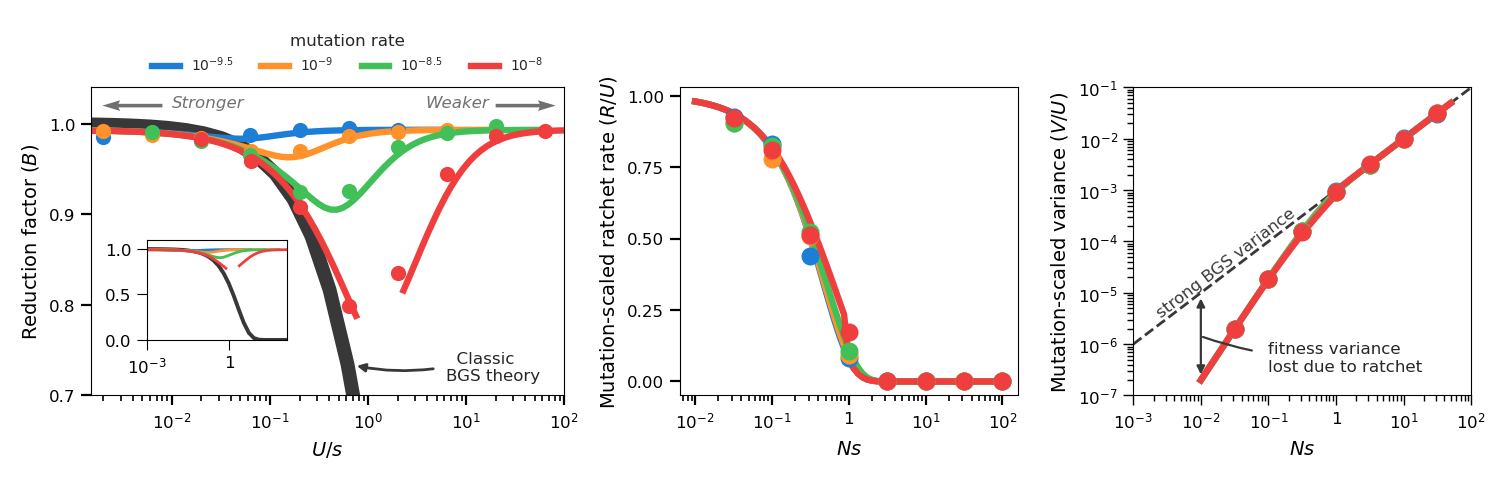

In [497]:
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['axes.labelpad'] = 3
#plt.rcParams['xtick.labelsize'] = 7
#plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.linewidth'] = 0.4


fig = plt.figure(constrained_layout=False, figsize=(7.5, 2))
subfigs = fig.subfigures(nrows=1, ncols=4, width_ratios=[1.4, 1, 0.04, 1], wspace=1)
#subfigs = fig.subplots(ncols=3, nrows=1, width_ratios=[1.3, 1, 1])
#subfig_A, subfig_B, subfig_C = subfigs

subfig_A = subfigs[0].subplots()
subfig_B = subfigs[1].subplots()
spacer = subfigs[2].subplots()
subfig_C = subfigs[3].subplots()

spacer.axis('off')

axin = inset_axes(subfig_A, width=0.7, height=0.5, loc=3, borderpad=2)

MUs = [3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08]

## MAIN CALLS
B_theory_plot(dg, L=L, rbp=rbp, N=N,
              mus=MUs,
              figax=(fig, subfig_A), data=theory_data,
              xlim=(0.0015, 100), include_asymp=False,
              #ylim=(0.70, 1.005), 
              ylim=(0.70, 1.04), 
              marker_size=30, bgs_zorder=1,
              legend=True, bgs_linewidth=5, linewidth=2.3)

# nested subplot
B_theory_plot(dg, L=L, rbp=rbp, N=N, 
              mus=MUs,
              figax=(fig, axin), data=theory_data,
              ylim=(0, 1.1), include_asymp=False, 
              legend=False, labels=False, bgs_zorder=-1, marker_size=0,
              bgs_linewidth=1.4, linewidth=1)



for item in ([axin.title, axin.xaxis.label, axin.yaxis.label] +
              axin.get_xticklabels() + axin.get_yticklabels()):
    item.set_fontsize(6)

axin.tick_params(axis="y", direction="out", pad=2)
axin.tick_params(axis="x", direction="out", pad=2)
axin_axeswidth = 0.4
for spine in ['top', 'right', 'left', 'bottom']:
    axin.spines[spine].set_visible(True)
    
    axin.spines[spine].set_linewidth(axin_axeswidth)
axin.xaxis.set_tick_params(width=axin_axeswidth)
axin.yaxis.set_tick_params(width=axin_axeswidth)
axin.xaxis.set_major_formatter(ticker.FuncFormatter(log10_formatter))

#subfig_A.spines[spine].set_visible(True)

# draw the box around zoomed-in region
draw_box = False
if draw_box:
    x, y = ax.axes.get_xlim(), ax.axes.get_ylim()
    zoom = mpl.patches.Rectangle((x[0], y[0]), x[1] - x[0], y[1] - y[0], 
                                 linewidth=0.1, edgecolor='0.22', facecolor='none')
    axin.add_patch(zoom)

#ax.axhline(1, linestyle='dashed', c='0.22', linewidth=1, zorder=-1)
#axin.axhline(1, linestyle='dashed', c='0.22', linewidth=0.5, zorder=-1)
# lh, ll = fig.axes[0].get_legend_handles_labels()

# leg = subfig_B.legend(handles=lh, labels=ll, title_fontsize=6, fontsize=6,
#                       title="mutation rate", framealpha=1, facecolor='white')
# #frame = leg.get_frame()
#frame.set_facecolor('blue')
arrowlab_y = 1.018
subfig_A.text(0.01, arrowlab_y, "Stronger", c='0.44', style='italic', fontsize=6)
subfig_A.quiver(0.008, 1.02, -0.6, 0, units='inches', scale_units='inches', scale=2, color='0.44', zorder=10)
subfig_A.text(3.8, arrowlab_y, "Weaker",  c='0.44', style='italic', fontsize=6)
subfig_A.quiver(20, 1.02, 0.6, 0, units='inches', scale_units='inches', scale=2, color='0.44', zorder=10)
subfig_A.annotate("  Classic\nBGS theory", xy=(0.55, 0.1), xytext=(0.75, 0.05), 
            backgroundcolor='white', 
             arrowprops=dict(arrowstyle="-|>", color='0.22', relpos=(0., 0.5),
                            connectionstyle="arc3,rad=-0.1"),
            xycoords=subfig_A.transAxes, fontsize=6)

subfig_A.set_ylabel("Reduction factor ($B$)")
subfig_A.set_xlabel("$U/s$")
#subfig_A.spines['left'].set_bounds((0.7, 1))
subfig_A.spines['right'].set_visible(True)
subfig_A.spines['top'].set_visible(True)
#ax.grid(linestyle='dashed')
subfig_A.set_axisbelow(True)
#axin.annotate("  Classic\nBGS theory", xy=(0.05, 0.1), fontsize=5)
subfig_A.set_yticks([0.7, 0.8, 0.9, 1])

# mask the grid behind arrows
# mask_grid_quiver = mpl.patches.Rectangle((0, 1.005), 100, 0.1, facecolor='white', zorder=1)
# subfig_A.add_patch(mask_grid_quiver)

# # mask grid behind legend
# mask_grid = mpl.patches.Rectangle((15, 0.2), 400, 0.8, facecolor='white', zorder=1)
# subfig_A.add_patch(mask_grid)
# subfig_A.xaxis.set_major_formatter(ticker.FuncFormatter(log10_formatter))
leg = subfig_A.legend(loc=(0.1, 1), ncols=4, fontsize=5, title_fontsize=6, title="mutation rate", framealpha=1, facecolor='white')


###### Subfigure B

ratchet_plot(theory_data, figax=(fig, subfig_B))
subfig_B.xaxis.set_major_formatter(ticker.FuncFormatter(log10_formatter))

###### Subfigure C
variance_plot(theory_data, figax=(fig, subfig_C))
subfig_C.annotate("strong BGS variance", (2e-3, 3.3e-6), xycoords='data', rotation=37.4, color='0.22', fontsize=6)

#fig.canvas.draw()
subfig_C.annotate("", xy=(1e-2, 1e-5), xytext=(1e-2, 2e-7), fontsize=6,
            xycoords='data', arrowprops=dict(color='0.22', arrowstyle='<|-|>', linewidth=0.8), zorder=20)

subfig_C.annotate("fitness variance\nlost due to ratchet", xy=(9e-3, 1.5e-6), xytext=(1e-1, 3e-7), horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=1, linewidth=0), 
            arrowprops=dict(color='0.22', connectionstyle="arc3,rad=-0.1", arrowstyle='-', linewidth=0.8),
            fontsize=6, rotation=0)
subfig_C.xaxis.set_major_formatter(ticker.FuncFormatter(log10_formatter))

subfig_C.set_ylim(1e-7, 1e-1)
subfig_C.set_xlim(1e-3, 1e2)


subfig_C.tick_params(axis='both', which='minor', width=0.5)
subfig_C.tick_params(axis='both', which='major', width=0.5)

fig.subplots_adjust(wspace=0.3)
#plt.tight_layout()
plt.savefig('../manuscript/figures/figure_1_top.pdf', bbox_inches='tight')

#### Mini-exploration of scaling

Tried to figure out how the ratchet slope comes about... without much luck

In [ ]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * np.exp(-b * x)

coefs = []

#theory_data[1e-8]
for r in rbps:
    for m in dg['mu'].unique():

        sN = theory_data_all[r][m][0] * N
        T = theory_data_all[r][m][4]
        y = 2/(T*2*L*m)
        plt.plot(sN, y)
        plt.semilogx()

        popt, pcov = curve_fit(func, sN, y)
        coefs.append(dict(rbp=r, mu=m, b=popt[1]))
        yfit = func(sN, popt[0], popt[1])
        plt.plot(sN, yfit)

In [ ]:
import seaborn as sns

In [ ]:
dcf = pd.DataFrame(coefs)
dcf['param'] = np.exp(-N * dcf['mu'] / np.sqrt(dcf['rbp']))

sns.scatterplot(x='param', y='b', data=dcf, hue='mu')
#plt.semilogx()

In [ ]:
dcfa = dcf.loc[dcf['mu'] < 1e-8]

x = dcfa['param']
y = dcfa['b']
plt.scatter(x, y)
xx = np.sort(x)
popt, pcov = curve_fit(func, x, y)
plt.plot(xx, func(xx, popt[0], popt[1]))
plt.semilogx()

### Figure 1D

#### Data

In [34]:
# load in subfigure D data
with open('../data/supplementary_data/figure_1_bmap_data.pkl', 'rb') as f:
    sibfigc_data = pickle.load(f)
    


g = sibfigc_data['g']
b = sibfigc_data['b']
bp = sibfigc_data['bp']
bp_rs = sibfigc_data['bp_rs']
m = sibfigc_data['m']
sim_means_100kb = sibfigc_data['sim_means_100kb']
sim_sd_100kb = sibfigc_data['sim_sd_100kb']

In [37]:
## do some processing for the recombination/gene density track

WIDTH = 100_000

i = np.zeros(g.seqlens['chr10'])
for row in m.segments.ranges:
    i[slice(*row)] = 1

covered_bases = np.where(i)[0]
wins = np.linspace(0, g.seqlens['chr10'], g.seqlens['chr10'] // WIDTH).astype(int)

# compute the coverage by binning covered bases and summing up indicator variables where they are
coverage = stats.binned_statistic(covered_bases, np.full(len(covered_bases), 1), statistic=np.sum, bins=wins)

In [38]:
# get the coverage stats end positions out
width = (coverage.bin_edges[1:] - coverage.bin_edges[:-1])
density_midpoints, density = (coverage.bin_edges[1:] + coverage.bin_edges[:-1])/2, 100*coverage.statistic/width

In [39]:
rec_ends, rec_rates = m.recmap.rates['chr10']

REC_WIDTH = 100_000
rec_wins = np.linspace(0, g.seqlens['chr10'], g.seqlens['chr10'] // REC_WIDTH).astype(int)

bin_rec = True

if bin_rec:
    rec_bins = stats.binned_statistic(rec_ends, rec_rates, statistic=np.nanmean, bins=rec_wins)
    rec_bin_rates = rec_bins.statistic
    rec_bin_midpoints = 0.5*(rec_bins.bin_edges[1:] + rec_bins.bin_edges[:-1])
else:
    rec_bin_rates = rec_rates
    rec_bin_midpoints = rec_ends
    
#rec_bin_rates[rec_bin_rates < 0] = np.nan
#rec_bin_rates = (rec_bin_rates - np.nanmean(rec_bin_rates)) / np.nanstd(rec_bin_rates)

In [40]:
def centro_notch(ax, coords, seqlen, c=2.5, lw=0.5, lc='0.22', flip=False):
    ymin, ymax = ax.get_ylim()
    m = 1/c if not flip else 1-1/c
    ymid = (ymin + ymax)*m
    if flip:
        ymin, ymax = ymax, ymin
    start, cent, end = coords
    verts = [(start, ymax*1.11), (cent, ymid), (end, ymax*1.11)]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO]
    centro_verts = mpath.Path(verts, codes)
    centro_marker = patches.PathPatch(centro_verts, facecolor='white', lw=0)
    ax.add_patch(centro_marker)
    ax.plot([0, 0, start, cent, end, seqlen, seqlen], [ymin, ymax, ymax, ymid, ymax, ymax, ymin], c=lc, linewidth=lw)

centro = read_centro("../data/annotation/hg38_centro.bed")

#### Figure Code

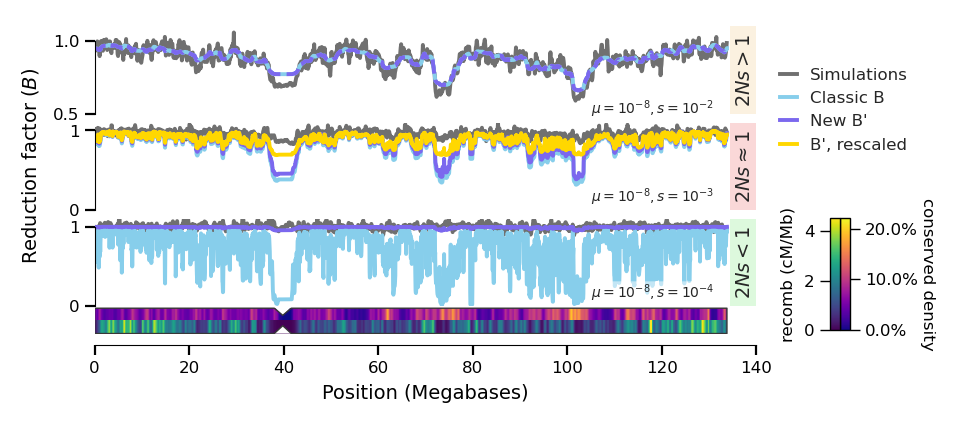

In [503]:
lwd = 1.4
newlab = "New B'"
ticks_x = mpl.ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1e6))

gridkw =  {"height_ratios": [5, 0.5, 5, 0.5, 5, 0.8, 0.8], "hspace": 0, "wspace": 0.05, "width_ratios": [3.5, 0.5],}#, "top": 0.01, "bottom": 0.0}
fig, axs = plt.subplots(ncols=2, nrows=7, gridspec_kw=gridkw, subplot_kw={'sharex': True}, sharex=True, figsize=(5, 2))

ax = axs[:, 0]

# right column is legend gutter so we don't have to use constrained layout 

spacers = [ax[1], ax[3]]
for spacer in spacers + axs[:, 1].tolist():
    spacer.axis('off')
gene_ax = ax[5]
rec_ax = ax[6]

COLS = ['0.44', 'skyblue', 'mediumslateblue', 'gold']

### Strong Selection B map
w, t = 1e-8, 1e-2 #3.16e-3
ax[0].plot(*sim_means_100kb['chr10', w, t], label="Simulations", linewidth=lwd, color=COLS[0])
ax[0].plot(*b['chr10', w, t], label="Classic BGS", linewidth=lwd, color=COLS[1])
ax[0].plot(*bp['chr10', w, t], label=newlab, linestyle='dashed', linewidth=lwd, color=COLS[2])
ax[0].set_ylim(0.5 , 1.1)
ax[0].get_xaxis().set_visible(False)
ax[0].spines.top.set_visible(False)
ax[0].spines.bottom.set_visible(False)
ax[0].spines.right.set_visible(False)
ax[0].spines.left.set_bounds((0.5, 1))

### Ns = 1 B Map
w, t = 1e-8, 1e-3
mb_bins = bin_chroms(g.seqlens, 40e3)
ax[2].plot(*sim_means_100kb['chr10', w, t], label="Simulations", linewidth=lwd,  color=COLS[0])
ax[2].plot(*b.bin_means(mb_bins)['chr10', w, t], label="Classic B", linewidth=lwd, color=COLS[1])
ax[2].plot(*bp['chr10', w, t], label=newlab, linewidth=lwd, color=COLS[2])
ax[2].plot(*bp_rs['chr10', w, t], label=f"B', rescaled", linewidth=lwd, color=COLS[3])
ax[2].set_ylim(0., 1.1)
ax[2].get_xaxis().set_visible(False)
ax[2].spines.top.set_visible(False)
ax[2].spines.bottom.set_visible(False)
ax[2].spines.right.set_visible(False)
ax[2].spines.left.set_bounds((0., 1))

### Weak Selection B map
#w, t = 3.16e-9, 1e-4
w, t = 1e-8, 1e-4
mb_bins = bin_chroms(g.seqlens, 40e3)
ax[4].plot(*sim_means_100kb['chr10', w, t], label="Simulations", linewidth=lwd,  color=COLS[0])
ax[4].plot(*b.bin_means(mb_bins)['chr10', w, t], label="Classic B", linewidth=lwd, color=COLS[1])
ax[4].plot(*bp['chr10', w, t], label=newlab, linewidth=lwd, color=COLS[2])
ax[4].set_ylim(0., 1.1)
ax[4].get_xaxis().set_visible(False)
ax[4].spines.top.set_visible(False)
ax[4].spines.bottom.set_visible(False)
ax[4].spines.right.set_visible(False)
ax[4].spines.left.set_bounds((0, 1))


### Gene Density / Recombination Map Chromosome
gene_ax.axis('off')
rec_ax.set_yticks([])
rec_ax.tick_params(left=False)
rec_ax.spines['bottom'].set_position(('outward', 4))
rec_ax.spines['bottom'].set_bounds([0, 140e6])
rec_ax.spines.right.set_visible(False)
rec_ax.spines.left.set_visible(False)
rec_ax.spines.top.set_visible(False)
rec_ax.xaxis.set_major_formatter(ticks_x)


bar_height = 10
#rate_min, rate_max = 0.9 * np.nanmin(rec_bin_rates), 0.90 * np.nanmax(rec_bin_rates)
rate_min, rate_max = np.nanquantile(rec_bin_rates, 0.01), np.nanquantile(rec_bin_rates, 0.95)

rec_bin_rates[np.isnan(rec_bin_rates)] = np.nanmin(rec_bin_rates)
smooth_rates = gaussian_filter1d(rec_bin_rates, 2)

norm = plt.Normalize(rate_min, rate_max)
rec_cbar = rec_ax.pcolor(rec_bin_midpoints, np.arange(bar_height), np.repeat(smooth_rates[:, None], bar_height, axis=1).T, 
                         norm=norm, cmap='viridis', alpha=1, snap=True,linewidth=0,rasterized=True)


norm = plt.Normalize(np.nanquantile(density, 0.01), np.nanquantile(density, 0.99))
smooth_rates = gaussian_filter1d(density, 2)
gene_cbar = gene_ax.pcolor(density_midpoints, np.arange(bar_height), np.repeat(smooth_rates[:, None], bar_height, axis=1).T, 
                           norm=norm, cmap='plasma', alpha=1, snap=True,linewidth=0,rasterized=True)
centro_notch(gene_ax, centro['chr10'], seqlen=g.seqlens['chr10'])
centro_notch(rec_ax, centro['chr10'],  seqlen=g.seqlens['chr10'], flip=True)


### BOTTOM LEGEND ---------------------------------------

lines, labels = fig.axes[4].get_legend_handles_labels()

# This dictionary will map labels to their corresponding lines.
# Because it's a dictionary, it will automatically remove duplicate labels.
#unique = {label: line for line, label in zip(lines, labels)}

# Now we can add the legend, using the unique labels and their corresponding lines.
leg = fig.legend(lines, labels, handlelength=1, fontsize=6, loc=(0.8, 0.6))

for handle in leg.legend_handles:
    handle.set_linestyle('solid')


# if show_sd:
#     simsd = sim_sd_100kb['chr10', w, t]
#     simm = sim_means_100kb['chr10', w, t]
#     ax[1].fill_between(simm[0], simm[1] - 0.5*simsd[1], simm[1] + 0.5*simsd[1], alpha=0.3)
#     simsd = sim_sd_100kb['chr10', w, t]
#     simm = sim_means_100kb['chr10', w, t]
#     ax[0].fill_between(simm[0], simm[1] - 0.5*simsd[1], simm[1] + 0.5*simsd[1], alpha=0.3)

#ax[1].grid(axis='y')
#ax[2].set_ylim(0, 1.1)
#ax[1].spines.left.set_bounds((0, 1))
#ax[2].spines.left.set_position(("axes", -0.005)) ##############
#ax[2].spines.right.set_visible(False)

#### Labels
import matplotlib.transforms as mtransforms
bx = 0.96
off = 0.008

ax[0].text(bx+off, 0.5, "$2Ns > 1$", rotation=90, va='center',
           transform=ax[0].transAxes, fontsize=7)
           #bbox=dict(boxstyle='square', pad=0.1, linewidth=0, facecolor='wheat', alpha=0.5))
ax[2].text(bx+off, 0.5, "$2Ns \\approx 1$", rotation=90, va='center',
           transform=ax[2].transAxes, fontsize=7)
ax[4].text(bx+off, 0.5, "$2Ns < 1$", rotation=90, va='center',
           transform=ax[4].transAxes, fontsize=7)

lx = 105e6
ax[0].text(lx, 0.5, "$\mu=10^{-8}, s=10^{-2}$", rotation=0, 
           transform=ax[0].transData, fontsize=5,
           bbox=dict(boxstyle='square', pad=0.1, linewidth=0, facecolor='white', alpha=0.5))

ax[2].text(lx, 0.1, "$\mu=10^{-8}, s=10^{-3}$", rotation=0, 
           transform=ax[2].transData, fontsize=5,
           bbox=dict(boxstyle='round', pad=0.1, linewidth=0, facecolor='white', alpha=0.5))

ax[4].text(lx, 0.1, "$\mu=10^{-8}, s=10^{-4}$", rotation=0, 
           transform=ax[4].transData, fontsize=5,
           bbox=dict(boxstyle='round', pad=0.1, linewidth=0, facecolor='white', alpha=0.5))


bw = 1
rect = plt.Rectangle((bx, 0), bw, 4, facecolor="wheat", alpha=0.4, transform=ax[0].transAxes,)
ax[0].add_patch(rect)

rect = plt.Rectangle((bx, 0), bw, 4, facecolor="lightcoral", alpha=0.3, transform=ax[2].transAxes,)
ax[2].add_patch(rect)

rect = plt.Rectangle((bx, 0), bw, 4, facecolor="lightgreen", alpha=0.3, transform=ax[4].transAxes,)
ax[4].add_patch(rect)

ax[0].set_xlim(0, 140e6)
rec_ax.set_xlabel("Position (Megabases)")
ax[2].set_ylabel("Reduction factor ($B$)", labelpad=10)

# the follow blocks out the patches from other axes which create weird white rectangles
ax[2].patch.set_visible(False)
ax[1].patch.set_visible(False)
ax[3].patch.set_visible(False)
ax[4].patch.set_visible(False)

offset = 0.1
width = 0.01
start = 0.76
yst = 0.12
hgt = 0.28
cax2 = fig.add_axes([offset+start+width, yst, width, hgt], zorder=100)
cax1 = fig.add_axes([offset+start, yst, width, hgt], zorder=100)
cbar1 = fig.colorbar(rec_cbar, cax=cax1, shrink=0.01)
cbar2 = fig.colorbar(gene_cbar, cax=cax2, shrink=0.01)
cax1.yaxis.set_ticks_position('left')
cax2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
cax1.set_yticks(np.array([0, 2e-8, 4e-8]))
cax1.set_yticklabels(np.array([0, 2, 4]))
cax1.yaxis.set_label_position('left')
cax1.set_ylabel('recomb (cM/Mb)', fontsize=6)
#cax1.yaxis.set_label_position('left')
cax2.set_ylabel('conserved density', fontsize=6, rotation=-90, labelpad=6)
cax1.tick_params(labelsize=6)
cax2.tick_params(labelsize=6)
cbar1.outline.set_linewidth(0.5)
#cbar1.outline.set_visible(False)
#cbar2.outline.set_visible(False)
cbar2.outline.set_linewidth(0.5) 
cax1.yaxis.set_tick_params(width=0.5)
cax2.yaxis.set_tick_params(width=0.5)

plt.savefig('../manuscript/figures/figure_1_track.pdf', bbox_inches='tight')

### Figure 1E

In [246]:
mse_df = pd.read_csv('../data/supplementary_data/theory_simulation_comparison.tsv', delimiter='\t')
mse_df.head()

,w,t,b_mse,bp_mse,bp_rs_mse,b_relerror,bp_relerror,bp_rs_relerror,b_bias,bp_bias,bp_rs_bias
0,1.000000e-10,0.000001,0.011050,0.001967,0.001967,0.055709,0.036007,0.001967,-0.026433,0.002873,0.002873
1,1.000000e-10,0.000003,0.005253,0.002074,0.002074,0.046148,0.036060,0.002074,-0.019844,-0.002311,-0.002311
2,1.000000e-10,0.000010,0.002817,0.001968,0.001968,0.038999,0.035310,0.001968,-0.010878,-0.000129,-0.000129
3,1.000000e-10,0.000032,0.002587,0.002218,0.002218,0.039364,0.037441,0.002218,-0.009135,-0.002062,-0.002056
4,1.000000e-10,0.000100,0.002130,0.002005,0.002004,0.036876,0.035822,0.002004,-0.005722,-0.001040,-0.000992


/tmp/ipykernel_45225/174307371.py:26: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)
/tmp/ipykernel_45225/174307371.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(('10%', '100%'))
/tmp/ipykernel_45225/174307371.py:39: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:
/tmp/ipykernel_45225/174307371.py:50: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


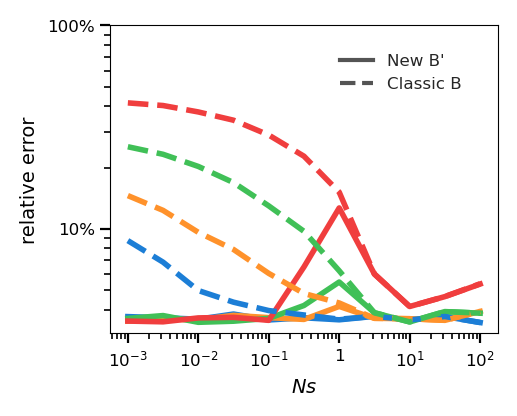

In [247]:
def rel_error_plot(mse_df, marker_size=5, linewidth=0.8, figax=None):
    fig, ax = get_figax(figax)
    labs = set()
    ws = set()
    for w in mse_df['w']:
        if w > 1e-8 or w == 1e-10:
            continue    
        if w in ws: 
            continue
        ws.add(w)
        mse_dfx = mse_df.loc[mse_df['w'] == w, :]
        expon = np.round(np.log10(w), 2)
        expon = int(expon) if int(expon) == expon else expon
        lab_text = f"$10^{{{expon}}}$"
        lab = None if lab_text in labs else lab_text
        lines = ax.plot(N*mse_dfx.t, 100*mse_dfx.bp_relerror, linewidth=linewidth, label=lab)
        labs.add(lab_text)
        #ax.scatter(mse_dfx.t, 100*mse_dfx.bp_relerror, c=lines[0].get_color(), s=marker_size, zorder=10)

        ax.plot(N*mse_dfx.t, 100*mse_dfx.b_relerror, linestyle='dashed',
                linewidth=linewidth,
                c=lines[0].get_color(), zorder=10)
        #ax.plot(N*mse_dfx.t, 100*mse_dfx.bp_rs_relerror, c=lines[0].get_color())
    ax.loglog()
    #ax.semilogx()
    ax.set_ylim(0, 100)
    #ax.set_xlim(1e-7, 1.1e-1)
    #ax.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    #ax.ticklabel_format(style='plain', axis='y',useOffset=False)
    ax.set_yticklabels(('10%', '100%'))
    ax.set_yticks((10, 100))
    ax.set_ylabel("relative error")
    ax.set_xlabel("$Ns$")
    

fig, ax = plt.subplots(figsize=(2.5, 2))
rel_error_plot(mse_df, marker_size=5, figax=(fig, ax), linewidth=2)
leg = ax.legend(fontsize=5, ncol=1, handlelength=1, title='mutation rate', title_fontsize=6)
for lh in leg.legendHandles:
    lh.set_markersize(0)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(log10_formatter))
#fig.add_artist(leg)


import matplotlib.lines as mlines

lineBPrime = mlines.Line2D([], [], color='0.33', linestyle='-', label="New B'", linewidth=2)
lineB = mlines.Line2D([], [], color='0.33', linestyle='--', label='Classic B', linewidth=2)
leg = ax.legend(handles=[lineBPrime, lineB], loc=(0.55, 0.73), fontsize=6, title_fontsize=8)
for lh in leg.legendHandles:
    lh.set_linewidth(1.5)
plt.savefig('../manuscript/figures/figure_1_relerror.pdf', bbox_inches='tight')

In [437]:
(mse_df['t']*N).unique()

array([1.00e-03, 3.16e-03, 1.00e-02, 3.16e-02, 1.00e-01, 3.16e-01,
       1.00e+00, 3.16e+00, 1.00e+01, 3.16e+01, 1.00e+02])

In [435]:
np.round(mse_df.mean() * 100, 2)

w                    0.00
t                    1.33
b_mse                7.38
bp_mse               0.53
bp_rs_mse            0.38
b_relerror          14.56
bp_relerror          5.03
bp_rs_relerror       0.38
b_bias             -11.68
bp_bias             -1.05
bp_rs_bias          -0.70
Ns                1329.29
dtype: float64

In [419]:
mse_df['Ns'] = N*mse_df['t']

In [434]:
np.round(mse_df.groupby(['w', 't']).mean() * 100, 2).reset_index()

,w,t,b_mse,bp_mse,bp_rs_mse,b_relerror,bp_relerror,bp_rs_relerror,b_bias,bp_bias,bp_rs_bias,Ns
0,1.000000e-10,0.000001,1.10,0.20,0.20,5.57,3.60,0.20,-2.64,0.29,0.29,0.10
1,1.000000e-10,0.000003,0.53,0.21,0.21,4.61,3.61,0.21,-1.98,-0.23,-0.23,0.32
2,1.000000e-10,0.000010,0.28,0.20,0.20,3.90,3.53,0.20,-1.09,-0.01,-0.01,1.00
3,1.000000e-10,0.000032,0.26,0.22,0.22,3.94,3.74,0.22,-0.91,-0.21,-0.21,3.16
4,1.000000e-10,0.000100,0.21,0.20,0.20,3.69,3.58,0.20,-0.57,-0.10,-0.10,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...
61,3.160000e-08,0.001000,13.51,10.59,6.61,36.32,31.57,6.61,-31.54,-27.31,-22.61,100.00
62,3.160000e-08,0.003160,2.80,2.80,2.72,19.56,19.58,2.72,-13.37,-13.38,-13.28,316.00
63,3.160000e-08,0.010000,0.18,0.18,0.18,5.42,5.42,0.18,-1.17,-1.18,-1.18,1000.00
64,3.160000e-08,0.031600,0.29,0.29,0.29,7.48,7.46,0.29,3.82,3.80,3.80,3160.00


In [420]:
np.round(mse_df.loc[mse_df['Ns'] == 1].groupby(['w']).mean() * 100, 2)

,t,b_mse,bp_mse,bp_rs_mse,b_relerror,bp_relerror,bp_rs_relerror,b_bias,bp_bias,bp_rs_bias,Ns
w,,,,,,,,,,,
1.000000e-10,0.1,0.23,0.23,0.23,3.88,3.89,0.23,0.41,0.44,0.49,100.0
3.160000e-10,0.1,0.20,0.20,0.19,3.59,3.57,0.19,-0.63,-0.52,-0.36,100.0
1.000000e-09,0.1,0.33,0.30,0.25,4.31,4.15,0.25,-2.18,-1.83,-1.35,100.0
3.160000e-09,0.1,0.68,0.51,0.30,6.21,5.47,0.30,-4.69,-3.69,-2.30,100.0
1.000000e-08,0.1,3.67,2.64,1.11,15.14,12.66,1.11,-13.99,-11.55,-8.26,100.0
3.160000e-08,0.1,13.51,10.59,6.61,36.32,31.57,6.61,-31.54,-27.31,-22.61,100.0


In [429]:
np.log10(mse_df['w'].unique()), np.log10(mse_df['t'].unique())

(array([-10.        ,  -9.50031292,  -9.        ,  -8.50031292,
         -8.        ,  -7.50031292]),
 array([-6.        , -5.50031292, -5.        , -4.50031292, -4.        ,
        -3.50031292, -3.        , -2.50031292, -2.        , -1.50031292,
        -1.        ]))

In [422]:
np.round(mse_df.loc[mse_df['Ns'] > 1].mean() * 100, 2)

w                    0.00
t                    3.62
b_mse                0.35
bp_mse               0.35
bp_rs_mse            0.35
b_relerror           5.22
bp_relerror          5.21
bp_rs_relerror       0.35
b_bias               0.09
bp_bias              0.08
bp_rs_bias           0.09
Ns                3619.00
dtype: float64

In [424]:
np.round(mse_df.loc[mse_df['Ns'] < 1].mean() * 100, 2)

w                  0.00
t                  0.01
b_mse             12.78
bp_mse             0.33
bp_rs_mse          0.23
b_relerror        21.28
bp_relerror        4.04
bp_rs_relerror     0.23
b_bias           -20.01
bp_bias           -0.74
bp_rs_bias        -0.39
Ns                 7.70
dtype: float64

In [412]:
np.round(mse_df.loc[mse_df['Ns'] < 2].mean() * 100, 2)

w                  0.00
t                  0.02
b_mse             11.40
bp_mse             0.63
bp_rs_mse          0.40
b_relerror        19.90
bp_relerror        4.93
bp_rs_relerror     0.40
b_bias           -18.41
bp_bias           -1.70
bp_rs_bias        -1.15
Ns                20.88
dtype: float64

/tmp/ipykernel_45225/3774294184.py:46: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:
/tmp/ipykernel_45225/3774294184.py:59: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


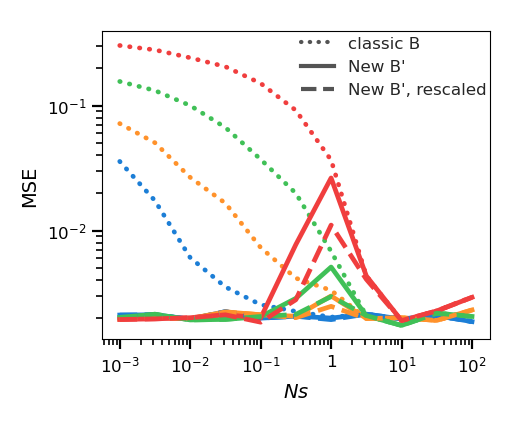

In [248]:
def mse_plot(mse_df, marker_size=5, linewidth=0.8, figax=None):
    fig, ax = get_figax(figax)
    labs = set()
    ws = set()
    for w in mse_df['w']:
        if w > 1e-8 or w == 1e-10:
            continue    
        if w in ws: 
            continue
        ws.add(w)
        mse_dfx = mse_df.loc[mse_df['w'] == w, :]
        expon = np.round(np.log10(w), 2)
        expon = int(expon) if int(expon) == expon else expon
        lab_text = f"$10^{{{expon}}}$"
        lab = None if lab_text in labs else lab_text
        lines = ax.plot(N*mse_dfx.t, mse_dfx.bp_mse, linewidth=linewidth, label=lab, zorder=10)
        labs.add(lab_text)
        #ax.scatter(mse_dfx.t, 100*mse_dfx.bp_relerror, c=lines[0].get_color(), s=marker_size, zorder=10)

        ax.plot(N*mse_dfx.t, mse_dfx.b_mse, #linestyle='dotted', 
                dash_capstyle = 'round',
                linestyle = (0,(0.1,2)),
                linewidth=linewidth,
                c=lines[0].get_color(), zorder=10)
        
        ax.plot(N*mse_dfx.t, mse_dfx.bp_rs_mse, c=lines[0].get_color(), linewidth=linewidth, linestyle='dashed', zorder=20)
        
        
    ax.loglog()
    #ax.semilogx()
    #ax.set_ylim(0, 100)
    #ax.set_xlim(1e-7, 1.1e-1)
    #ax.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    #ax.ticklabel_format(style='plain', axis='y',useOffset=False)
    #ax.set_yticklabels(('10%', '100%'))
    #ax.set_yticks((10, 100))
    ax.set_ylabel("MSE")
    ax.set_xlabel("$Ns$")

    


fig, ax = plt.subplots(figsize=(2.5, 2))
mse_plot(mse_df, marker_size=5, figax=(fig, ax), linewidth=1.7)
leg = ax.legend(fontsize=5, ncol=1, handlelength=1, title='mutation rate', title_fontsize=6)
for lh in leg.legendHandles:
    lh.set_markersize(0)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(log10_formatter))
#fig.add_artist(leg)


import matplotlib.lines as mlines

lineBp = mlines.Line2D([], [], color='0.33', linestyle='-', label="New B'", linewidth=2)
lineB = mlines.Line2D([], [], color='0.33', dash_capstyle = 'round',
                linestyle = (0,(0.1,2)), label='classic B', linewidth=2) 
lineBp_rs = mlines.Line2D([], [], color='0.33', linestyle='dashed', label="New B', rescaled", linewidth=2)
leg = ax.legend(handles=[lineB, lineBp, lineBp_rs, ], loc=(0.47, 0.73), fontsize=6, title_fontsize=8)
for lh in leg.legendHandles:
    lh.set_linewidth(1.5)
    

#### With LD Data

In [53]:
sim_B = np.load('../slim_sims/chrombgs/empiricalB_chr10__expansion_false__h_0.5__results.npz', allow_pickle=True)
mus = sim_B['mu']
shs = sim_B['sh']

Text(0.5, 0, '$Ns$')

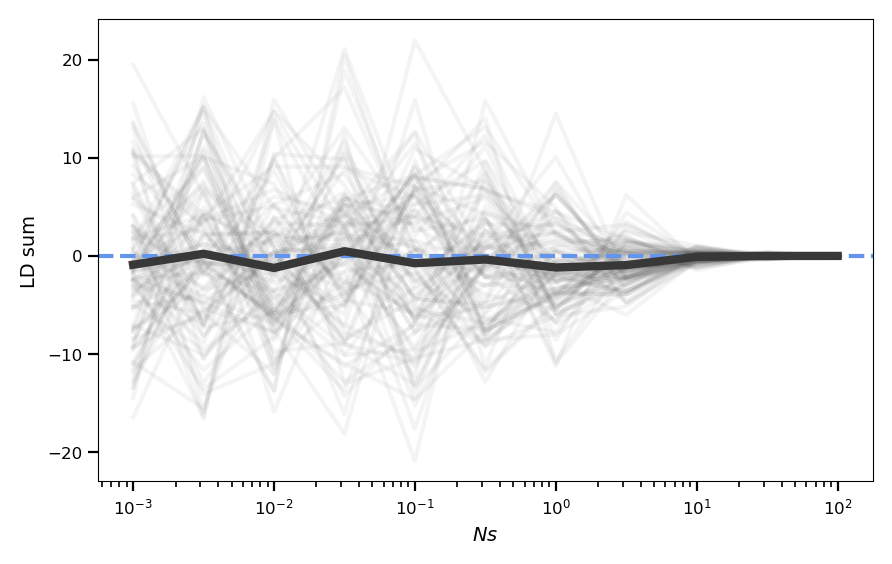

In [87]:
mi = 4

fig, ax = plt.subplots(figsize=(5, 3))
for i in range(100):
    ax.plot(N*shs, sim_B['r2sum'][mi, :, i], c='0.22', alpha=0.05)
ax.plot(N*shs, sim_B['r2sum'].mean(axis=2)[mi, :], linewidth=3, c='0.22', zorder=10)
ax.axhline(0, c='cornflowerblue', linestyle='dashed')
ax.semilogx()
ax.set_ylabel('LD sum')
ax.set_xlabel('$Ns$')

Text(0.5, 0, '$Ns$')

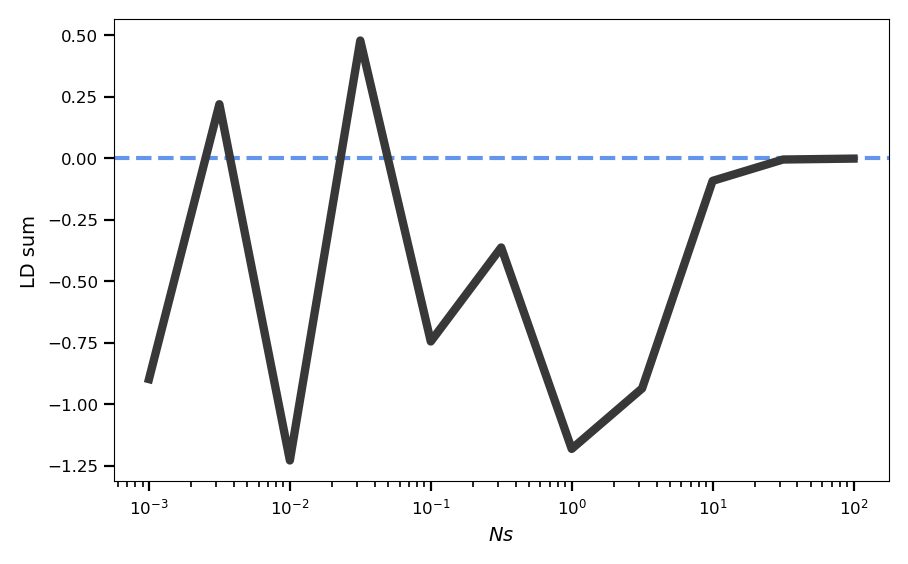

In [93]:
mi =4

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(N*shs, sim_B['r2sum'].mean(axis=2)[mi, :], linewidth=3, c='0.22', zorder=10)
ax.axhline(0, c='cornflowerblue', linestyle='dashed')
ax.semilogx()
ax.set_ylabel('LD sum')
ax.set_xlabel('$Ns$')

/tmp/ipykernel_45225/647516364.py:17: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d
/tmp/ipykernel_45225/647516364.py:57: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


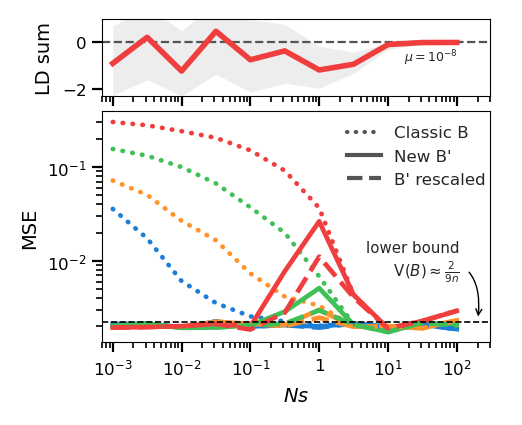

In [443]:
gridkw =  {"height_ratios": [1, 3], "hspace": 0.1}#, "top": 0.01, "bottom": 0.0}

fig, ax = plt.subplots(nrows=2, figsize=(2.5, 2.1), gridspec_kw=gridkw, subplot_kw={'sharex': True}, sharex=True,)


mi = 4
for i in range(100):
    #ax[0].plot(N*shs, sim_B['r2sum'][mi, :, i], c='0.22', linewidth=1, alpha=0.05)
    continue
mean = sim_B['r2sum'].mean(axis=2)[mi, :]
ax[0].plot(N*shs, mean, linewidth=2, c='#f03e3e', zorder=10, label=mu)

sd = sim_B['r2sum'].std(axis=2)[mi, :]
n = sim_B['r2sum'].shape[2]


from scipy.ndimage.filters import gaussian_filter1d
mean = gaussian_filter1d(mean, sigma=0.5)
sd = gaussian_filter1d(sd, sigma=0.5)

ax[0].fill_between(N*shs, mean - 2*sd/np.sqrt(n), mean + 2*sd/np.sqrt(n), alpha=0.1, linewidth=0, color='0.33')

# mi = 5
# for i in range(100):
#     ax[0].plot(N*shs, sim_B['r2sum'][mi, :, i], c='0.22', linewidth=1, alpha=0.05)
#     continue
# ax[0].plot(N*shs, sim_B['r2sum'].mean(axis=2)[mi, :], linewidth=2, zorder=10, label=mu)


# for i, mu in enumerate(mus):
#     if mu == 3.16e-8 or mu == 1e-10:
#         continue
#     xx = sim_B['r2sum'].mean(axis=2)[i, :]
#     ax[0].plot(N*shs, xx / np.std(xx), linewidth=2, zorder=10, label=mu)
ax[0].axhline(0, c='0.33', linewidth=0.8, linestyle='dashed')
ax[0].semilogx()
ax[0].set_ylabel('LD sum')
ax[0].set_xlabel('$Ns$')


mse_plot(mse_df, marker_size=5, figax=(fig, ax[1]), linewidth=1.7)
#leg = ax[1].legend(fontsize=5, ncol=1, handlelength=1, title='mutation rate', title_fontsize=6)
#for lh in leg.legendHandles:
#    lh.set_markersize(0)
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(log10_formatter))
#fig.add_artist(leg)


import matplotlib.lines as mlines

lineBp = mlines.Line2D([], [], color='0.33', linestyle='-', label="New B'", linewidth=2)
lineB = mlines.Line2D([], [], color='0.33', dash_capstyle = 'round',
                linestyle = (0,(0.1,2)), label='Classic B', linewidth=2) 
lineBp_rs = mlines.Line2D([], [], color='0.33', linestyle='dashed', label="B' rescaled", linewidth=2)
 
leg = ax[1].legend(handles=[lineB, lineBp, lineBp_rs, ], loc=(0.59, 0.6), fontsize=6, title_fontsize=8)
for lh in leg.legendHandles:
    lh.set_linewidth(1.5)
    

from bgspy.theory2 import B_var_limit
nsims = 100 
ax[1].axhline(B_(1, nsims), c='k', zorder=20, linestyle='dashed', linewidth=0.6)
ax[1].annotate("lower bound\n $\mathrm{V}(B) \\approx \\frac{2}{9n}$", (200, B_var_limit(1, nsims)), (110, 7e-3),
               ha='right', zorder=10, 
               fontsize=5.4, arrowprops=dict(facecolor='black', linewidth=0.5, arrowstyle="->", connectionstyle="arc3,rad=-0.7"))
# ax[1].annotate("theoretical\nlimit", (5e-4, B_var_limit(1, nsims)), (1e-3, 6e-3),
#                ha='center', zorder=10,
#                fontsize=5, arrowprops=dict(facecolor='black', arrowstyle="->", connectionstyle="arc3"))

#ax[1].set_xlim(2e-4, 200)
ax[1].set_xlim(7e-4, 300)

#ax[0].set_ylim(-13, 13)
ax[0].set_ylim(-2.3, 1)

ax[0].text(17, -0.8, "$\mu = 10^{-8}$", fontsize=4.5)

plt.savefig('../manuscript/figures/figure_1_relerror_LD.pdf', bbox_inches='tight')

In [ ]:
def split_chrom_ax(ax, rec_x, rec_y, gen_x, gen_y, rec_quantile=(0.01, 0.95), gen_quantile=(0.01, 0.99)):
    bar_height = 10
    rec_ax, gen_ax = ax
    rate_min, rate_max = np.nanquantile(rec_y, rec_quantile[0]), np.nanquantile(rec_y, rec_quantile[1])

    rec_y[np.isnan(rec_y)] = np.nanmin(rec_y)
    smooth_rec_y = gaussian_filter1d(rec_y, 2)

    rec_norm = plt.Normalize(rate_min, rate_max)
    rec_cbar = rec_ax.pcolor(rec_x, np.arange(bar_height), np.repeat(smooth_rec_y[:, None], bar_height, axis=1).T, 
                             norm=rec_norm, cmap='viridis', alpha=1, snap=True, linewidth=0, rasterized=True)


    gen_norm = plt.Normalize(np.nanquantile(density, gen_quantile[0]), np.nanquantile(density, gen_quantile[1]))
    smooth_gen_y = gaussian_filter1d(density, 2)
    gen_cbar = gen_ax.pcolor(gen_x, np.arange(bar_height), np.repeat(smooth_gen_y[:, None], bar_height, axis=1).T, 
                             norm=gen_norm, cmap='plasma', 
                             # the follow options get rid of those nasty lines in PDF
                             alpha=1, snap=True, linewidth=0, rasterized=True)

    return rec_cbar, gen_cbar